In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
S, P = np.load("../data/dataset.npy")
molecules = np.load("../data/molecules.npy")

In [3]:
def extract_triu(A):
    """Extracts the upper triangular part of the matrix.
    Input can be matrix, will be reshaped if it is not.
    """
    return A.reshape(dim, dim)[np.triu_indices(dim)]

def reconstruct_from_triu(A_flat):
    """Reconstructus the full symmetric matrix (dim x dim, not
    flattened out) from the flattend elements of the upper 
    triag of a symmetric matrix!"""
    result = np.zeros((dim, dim))
    result[np.triu_indices(dim)] = A_flat
    return result + result.T - np.diag(np.diag(result))


In [4]:
from SCFInitialGuess.utilities.dataset import Dataset

dim = 26
dim_triu = int(dim * (dim + 1) / 2)

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_triu = list(map(extract_triu, S))
P_triu = list(map(extract_triu, P))

S_test = np.array(S_triu)[index[150:]]
P_test = np.array(P_triu)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S_triu)[index[:150]]
P_train = np.array(P_triu)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-03-28 21:21:33: Data set normalized. Mean value std: 0.008441599944217284


In [6]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer
from SCFInitialGuess.nn.cost_functions import RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim_triu, 400, 400, 400, 400, dim_triu]),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer.setup()
network, sess = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph = trainer.graph

[-] 2018-03-28 21:24:49: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-28 21:24:49: Setting up the training in the target graph ...
[-] 2018-03-28 21:24:49: network ...
[-] 2018-03-28 21:24:49: error function ...
[-] 2018-03-28 21:24:49: cost function ...
[-] 2018-03-28 21:24:49: training step
[-] 2018-03-28 21:24:49: Starting network training ...
[ ] 2018-03-28 21:24:49: Val. Cost: 9.497E-02. Error: 9.497E-02. Diff: 1.0E+10
[ ] 2018-03-28 21:24:51: Val. Cost: 3.105E-04. Error: 3.067E-04. Diff: 9.5E-02
[ ] 2018-03-28 21:24:52: Val. Cost: 1.260E-04. Error: 1.220E-04. Diff: 1.8E-04
[ ] 2018-03-28 21:24:53: Val. Cost: 5.663E-05. Error: 5.245E-05. Diff: 6.9E-05
[ ] 2018-03-28 21:24:54: Val. Cost: 5.072E-05. Error: 4.630E-05. Diff: 6.2E-06
[ ] 2018-03-28 21:24:55: Val. Cost: 1.644E-05. Error: 1.198E-05. Diff: 3.4E-05
[ ] 2018-03-28 21:24:57: Val. Cost: 1.597E-05. Error: 1.154E-05. Diff: 4.4E-07
[ ] 2018-03-28 21:24:58: Val. Cost: 2.135E-05. Error: 1.686E-05

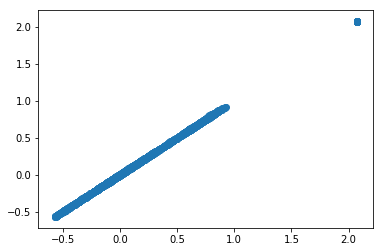

In [7]:
#from SCFInitialGuess.utilities.analysis import prediction_scatter
import matplotlib.pyplot as plt

with graph.as_default():
    plt.scatter(
        dataset.testing[1].flatten(), 
        network.run(sess, dataset.testing[0]).flatten()
    )
plt.show()

In [8]:
def mc_wheeny_purification(p,s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return (3 * np.dot(np.dot(p, s), p) - np.dot(np.dot(np.dot(np.dot(p, s), p), s), p)) / 2

def multi_mc_wheeny(p, s, n_max=4):
    for i in range(n_max):
        p = mc_wheeny_purification(p, s)
    return p

def idemp_error(p, s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return np.mean(np.abs(np.dot(np.dot(p, s), p) - 2 * p))

In [9]:
P_NN_multi = []
for (s, p) in zip(*dataset.testing):
#for (s, p) in zip(S_test, P_test):
    
    #s_norm = s.reshape(1, dim**2)
    s_raw = reconstruct_from_triu(dataset.inverse_input_transform(s))
    p_raw = reconstruct_from_triu(p)
    
    
    print("Orig:         {:0.3E}".format(idemp_error(p_raw, s_raw))) 
    
    with graph.as_default():
        p_nn = reconstruct_from_triu(network.run(sess, s.reshape(1, dim_triu)))
        
    print("NN:           {:0.3E}".format(idemp_error(p_nn, s_raw)))
    print("NN pruified:  {:0.3E}".format(idemp_error(mc_wheeny_purification(p_nn, s_raw), s_raw)))
    p_nn_multi = multi_mc_wheeny(p_nn, s_raw, n_max=5)
    
    P_NN_multi.append(extract_triu(p_nn_multi))
    print("NN multified: {:0.3E}".format(idemp_error(p_nn_multi, s_raw))) 
    print("Error NN before: {:0.3E}".format(np.mean(np.abs(p_raw - p_nn))))
    print("Error NN multifed:  {:0.3E}".format(np.mean(np.abs(p_raw - p_nn_multi))))
    print("---------------------------")

Orig:         2.909E-16
NN:           2.185E-03
NN pruified:  6.709E-05
NN multified: 6.593E-17
Error NN before: 1.529E-03
Error NN multifed:  1.047E-03
---------------------------
Orig:         2.535E-16
NN:           2.080E-03
NN pruified:  4.884E-05
NN multified: 6.960E-17
Error NN before: 1.384E-03
Error NN multifed:  9.056E-04
---------------------------
Orig:         3.228E-16
NN:           2.419E-03
NN pruified:  5.711E-05
NN multified: 7.031E-17
Error NN before: 1.756E-03
Error NN multifed:  1.310E-03
---------------------------
Orig:         2.818E-16
NN:           2.116E-03
NN pruified:  5.746E-05
NN multified: 6.742E-17
Error NN before: 1.553E-03
Error NN multifed:  1.136E-03
---------------------------
Orig:         2.967E-16
NN:           2.145E-03
NN pruified:  5.563E-05
NN multified: 6.872E-17
Error NN before: 1.739E-03
Error NN multifed:  1.441E-03
---------------------------
Orig:         3.042E-16
NN:           2.178E-03
NN pruified:  6.660E-05
NN multified: 6.675E-17

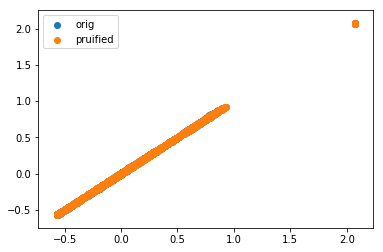

In [10]:
with graph.as_default():
    plt.scatter(
        dataset.testing[1].flatten(), 
        network.run(sess, dataset.testing[0]).flatten(),
        label="orig"
    )
    plt.scatter(
        dataset.testing[1].flatten(), 
        np.array(P_NN_multi).flatten(),
        label="pruified"
    )
plt.legend()
plt.show()

In [26]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.analysis import prediction_scatter

keys = ["minao", "noise", "nn", "nn_purified"]

iterations = {}
for k in keys:
    iterations[k] = []

for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    guesses = {}

    s_raw = hf.get_ovlp(mol)
    s_norm = dataset.input_transformation(extract_triu(s_raw)).reshape(1, dim_triu)
    
    # pyscf init guess
    p_minao = hf.init_guess_by_minao(mol)
    guesses["minao"] = p_minao
        
    # P_actual wi noise
    p_raw = reconstruct_from_triu(p)
    p_noise = p_raw + np.random.randn(dim, dim) * 1e-3
    guesses["noise"] = p_noise
    
    
    with graph.as_default():
        p_orig = reconstruct_from_triu(network.run(sess, s_norm)).astype('float64')
        
    guesses["nn"] = p_orig


    p_purified = multi_mc_wheeny(p_orig, s_raw, n_max=5)
    guesses["nn_purified"] = p_purified

    # check errors
    print("Accuracy (MSE):")
    print(" -Noise: {:0.3E}".format(np.mean(np.abs(p_raw - p_noise))))
    print(" -NN:    {:0.3E}".format(np.mean(np.abs(p_raw - p_orig))))
    print(" -Pruif: {:0.3E}".format(np.mean(np.abs(p_raw - p_purified))))
    print(" -minao: {:0.3E}".format(np.mean(np.abs(p_raw - p_minao))))
    

    print("Idempotency:")
    print(" -Noise: {:0.3E}".format(idemp_error(p_noise, s_raw)))
    print(" -Orig:  {:0.3E}".format(idemp_error(p_orig, s_raw)))
    print(" -Purif: {:0.3E}".format(idemp_error(p_purified, s_raw)))
    print(" -minao: {:0.3E}".format(idemp_error(p_minao, s_raw)))

    
    
    for (key, guess) in guesses.items():
        mf = hf.RHF(mol)
        mf.diis = None
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations[key].append(mf.iterations)

        
for k in keys:
    iterations[k] = np.array(iterations[k])

Warn: Ipython shell catchs sys.args


Calculating: 1/50
Accuracy (MSE):
 -Noise: 7.625E-04
 -NN:    1.529E-03
 -Pruif: 1.047E-03
 -minao: 8.363E-02
Idempotency:
 -Noise: 1.090E-03
 -Orig:  2.185E-03
 -Purif: 6.307E-17
 -minao: 1.267E-01


Warn: Ipython shell catchs sys.args


Calculating: 2/50
Accuracy (MSE):
 -Noise: 8.144E-04
 -NN:    1.384E-03
 -Pruif: 9.056E-04
 -minao: 8.210E-02
Idempotency:
 -Noise: 1.200E-03
 -Orig:  2.080E-03
 -Purif: 6.567E-17
 -minao: 1.249E-01


Warn: Ipython shell catchs sys.args


Calculating: 3/50
Accuracy (MSE):
 -Noise: 7.752E-04
 -NN:    1.756E-03
 -Pruif: 1.310E-03
 -minao: 8.224E-02
Idempotency:
 -Noise: 1.137E-03
 -Orig:  2.419E-03
 -Purif: 6.248E-17
 -minao: 1.216E-01


Warn: Ipython shell catchs sys.args


Calculating: 4/50
Accuracy (MSE):
 -Noise: 7.677E-04
 -NN:    1.553E-03
 -Pruif: 1.136E-03
 -minao: 8.403E-02
Idempotency:
 -Noise: 1.136E-03
 -Orig:  2.116E-03
 -Purif: 6.352E-17
 -minao: 1.250E-01


Warn: Ipython shell catchs sys.args


Calculating: 5/50
Accuracy (MSE):
 -Noise: 8.265E-04
 -NN:    1.739E-03
 -Pruif: 1.441E-03
 -minao: 8.190E-02
Idempotency:
 -Noise: 1.175E-03
 -Orig:  2.145E-03
 -Purif: 6.603E-17
 -minao: 1.221E-01


Warn: Ipython shell catchs sys.args


Calculating: 6/50
Accuracy (MSE):
 -Noise: 7.795E-04
 -NN:    1.542E-03
 -Pruif: 1.064E-03
 -minao: 8.375E-02
Idempotency:
 -Noise: 1.121E-03
 -Orig:  2.178E-03
 -Purif: 6.188E-17
 -minao: 1.264E-01


Warn: Ipython shell catchs sys.args


Calculating: 7/50
Accuracy (MSE):
 -Noise: 7.808E-04
 -NN:    1.831E-03
 -Pruif: 1.304E-03
 -minao: 8.357E-02
Idempotency:
 -Noise: 1.221E-03
 -Orig:  2.453E-03
 -Purif: 6.856E-17
 -minao: 1.276E-01


Warn: Ipython shell catchs sys.args


Calculating: 8/50
Accuracy (MSE):
 -Noise: 7.794E-04
 -NN:    1.671E-03
 -Pruif: 1.236E-03
 -minao: 8.352E-02
Idempotency:
 -Noise: 1.096E-03
 -Orig:  2.273E-03
 -Purif: 6.758E-17
 -minao: 1.230E-01


Warn: Ipython shell catchs sys.args


Calculating: 9/50
Accuracy (MSE):
 -Noise: 8.006E-04
 -NN:    1.426E-03
 -Pruif: 1.037E-03
 -minao: 8.413E-02
Idempotency:
 -Noise: 1.165E-03
 -Orig:  1.988E-03
 -Purif: 6.175E-17
 -minao: 1.250E-01


Warn: Ipython shell catchs sys.args


Calculating: 10/50
Accuracy (MSE):
 -Noise: 7.865E-04
 -NN:    1.426E-03
 -Pruif: 1.047E-03
 -minao: 8.289E-02
Idempotency:
 -Noise: 1.110E-03
 -Orig:  2.017E-03
 -Purif: 7.403E-17
 -minao: 1.246E-01


Warn: Ipython shell catchs sys.args


Calculating: 11/50
Accuracy (MSE):
 -Noise: 8.490E-04
 -NN:    1.421E-03
 -Pruif: 9.721E-04
 -minao: 8.399E-02
Idempotency:
 -Noise: 1.262E-03
 -Orig:  2.118E-03
 -Purif: 7.045E-17
 -minao: 1.262E-01


Warn: Ipython shell catchs sys.args


Calculating: 12/50
Accuracy (MSE):
 -Noise: 7.618E-04
 -NN:    1.692E-03
 -Pruif: 1.205E-03
 -minao: 8.383E-02
Idempotency:
 -Noise: 1.108E-03
 -Orig:  2.295E-03
 -Purif: 7.266E-17
 -minao: 1.272E-01


Warn: Ipython shell catchs sys.args


Calculating: 13/50
Accuracy (MSE):
 -Noise: 8.099E-04
 -NN:    1.513E-03
 -Pruif: 1.139E-03
 -minao: 8.216E-02
Idempotency:
 -Noise: 1.193E-03
 -Orig:  2.043E-03
 -Purif: 6.906E-17
 -minao: 1.248E-01


Warn: Ipython shell catchs sys.args


Calculating: 14/50
Accuracy (MSE):
 -Noise: 7.929E-04
 -NN:    1.573E-03
 -Pruif: 1.118E-03
 -minao: 8.275E-02
Idempotency:
 -Noise: 1.230E-03
 -Orig:  2.418E-03
 -Purif: 7.392E-17
 -minao: 1.220E-01


Warn: Ipython shell catchs sys.args


Calculating: 15/50
Accuracy (MSE):
 -Noise: 7.800E-04
 -NN:    1.767E-03
 -Pruif: 1.510E-03
 -minao: 8.184E-02
Idempotency:
 -Noise: 1.177E-03
 -Orig:  2.182E-03
 -Purif: 6.515E-17
 -minao: 1.224E-01


Warn: Ipython shell catchs sys.args


Calculating: 16/50
Accuracy (MSE):
 -Noise: 7.376E-04
 -NN:    1.539E-03
 -Pruif: 1.108E-03
 -minao: 8.195E-02
Idempotency:
 -Noise: 1.089E-03
 -Orig:  2.349E-03
 -Purif: 6.412E-17
 -minao: 1.238E-01


Warn: Ipython shell catchs sys.args


Calculating: 17/50
Accuracy (MSE):
 -Noise: 7.753E-04
 -NN:    1.362E-03
 -Pruif: 1.063E-03
 -minao: 8.225E-02
Idempotency:
 -Noise: 1.162E-03
 -Orig:  1.824E-03
 -Purif: 6.294E-17
 -minao: 1.229E-01


Warn: Ipython shell catchs sys.args


Calculating: 18/50
Accuracy (MSE):
 -Noise: 7.905E-04
 -NN:    1.597E-03
 -Pruif: 1.059E-03
 -minao: 8.190E-02
Idempotency:
 -Noise: 1.154E-03
 -Orig:  2.431E-03
 -Purif: 6.679E-17
 -minao: 1.260E-01


Warn: Ipython shell catchs sys.args


Calculating: 19/50
Accuracy (MSE):
 -Noise: 7.746E-04
 -NN:    1.513E-03
 -Pruif: 1.132E-03
 -minao: 8.218E-02
Idempotency:
 -Noise: 1.146E-03
 -Orig:  2.161E-03
 -Purif: 6.319E-17
 -minao: 1.235E-01


Warn: Ipython shell catchs sys.args


Calculating: 20/50
Accuracy (MSE):
 -Noise: 8.049E-04
 -NN:    1.887E-03
 -Pruif: 1.467E-03
 -minao: 8.232E-02
Idempotency:
 -Noise: 1.126E-03
 -Orig:  2.443E-03
 -Purif: 6.652E-17
 -minao: 1.210E-01


Warn: Ipython shell catchs sys.args


Calculating: 21/50
Accuracy (MSE):
 -Noise: 8.017E-04
 -NN:    1.347E-03
 -Pruif: 9.178E-04
 -minao: 8.181E-02
Idempotency:
 -Noise: 1.222E-03
 -Orig:  2.028E-03
 -Purif: 7.297E-17
 -minao: 1.235E-01


Warn: Ipython shell catchs sys.args


Calculating: 22/50
Accuracy (MSE):
 -Noise: 7.894E-04
 -NN:    2.872E-03
 -Pruif: 2.068E-03
 -minao: 8.286E-02
Idempotency:
 -Noise: 1.235E-03
 -Orig:  3.988E-03
 -Purif: 6.556E-17
 -minao: 1.256E-01


Warn: Ipython shell catchs sys.args


Calculating: 23/50
Accuracy (MSE):
 -Noise: 7.568E-04
 -NN:    1.436E-03
 -Pruif: 9.796E-04
 -minao: 8.277E-02
Idempotency:
 -Noise: 1.112E-03
 -Orig:  2.105E-03
 -Purif: 7.168E-17
 -minao: 1.244E-01


Warn: Ipython shell catchs sys.args


Calculating: 24/50
Accuracy (MSE):
 -Noise: 7.947E-04
 -NN:    1.509E-03
 -Pruif: 1.015E-03
 -minao: 8.221E-02
Idempotency:
 -Noise: 1.156E-03
 -Orig:  2.157E-03
 -Purif: 7.142E-17
 -minao: 1.218E-01


Warn: Ipython shell catchs sys.args


Calculating: 25/50
Accuracy (MSE):
 -Noise: 8.012E-04
 -NN:    1.631E-03
 -Pruif: 1.207E-03
 -minao: 8.372E-02
Idempotency:
 -Noise: 1.177E-03
 -Orig:  2.218E-03
 -Purif: 6.689E-17
 -minao: 1.255E-01


Warn: Ipython shell catchs sys.args


Calculating: 26/50
Accuracy (MSE):
 -Noise: 8.268E-04
 -NN:    1.566E-03
 -Pruif: 1.184E-03
 -minao: 8.249E-02
Idempotency:
 -Noise: 1.153E-03
 -Orig:  2.312E-03
 -Purif: 6.429E-17
 -minao: 1.209E-01


Warn: Ipython shell catchs sys.args


Calculating: 27/50
Accuracy (MSE):
 -Noise: 8.178E-04
 -NN:    1.576E-03
 -Pruif: 1.118E-03
 -minao: 8.293E-02
Idempotency:
 -Noise: 1.153E-03
 -Orig:  2.298E-03
 -Purif: 6.040E-17
 -minao: 1.264E-01


Warn: Ipython shell catchs sys.args


Calculating: 28/50
Accuracy (MSE):
 -Noise: 8.017E-04
 -NN:    1.590E-03
 -Pruif: 1.198E-03
 -minao: 8.172E-02
Idempotency:
 -Noise: 1.254E-03
 -Orig:  2.133E-03
 -Purif: 5.988E-17
 -minao: 1.229E-01


Warn: Ipython shell catchs sys.args


Calculating: 29/50
Accuracy (MSE):
 -Noise: 8.028E-04
 -NN:    1.630E-03
 -Pruif: 1.228E-03
 -minao: 8.220E-02
Idempotency:
 -Noise: 1.179E-03
 -Orig:  2.252E-03
 -Purif: 7.223E-17
 -minao: 1.220E-01


Warn: Ipython shell catchs sys.args


Calculating: 30/50
Accuracy (MSE):
 -Noise: 7.690E-04
 -NN:    1.860E-03
 -Pruif: 1.299E-03
 -minao: 8.277E-02
Idempotency:
 -Noise: 1.112E-03
 -Orig:  2.690E-03
 -Purif: 5.908E-17
 -minao: 1.255E-01


Warn: Ipython shell catchs sys.args


Calculating: 31/50
Accuracy (MSE):
 -Noise: 7.869E-04
 -NN:    1.615E-03
 -Pruif: 1.124E-03
 -minao: 8.292E-02
Idempotency:
 -Noise: 1.153E-03
 -Orig:  2.540E-03
 -Purif: 6.680E-17
 -minao: 1.224E-01


Warn: Ipython shell catchs sys.args


Calculating: 32/50
Accuracy (MSE):
 -Noise: 7.765E-04
 -NN:    1.539E-03
 -Pruif: 1.154E-03
 -minao: 8.264E-02
Idempotency:
 -Noise: 1.181E-03
 -Orig:  2.284E-03
 -Purif: 7.967E-17
 -minao: 1.222E-01


Warn: Ipython shell catchs sys.args


Calculating: 33/50
Accuracy (MSE):
 -Noise: 7.760E-04
 -NN:    1.309E-03
 -Pruif: 9.514E-04
 -minao: 8.146E-02
Idempotency:
 -Noise: 1.132E-03
 -Orig:  1.838E-03
 -Purif: 6.617E-17
 -minao: 1.231E-01


Warn: Ipython shell catchs sys.args


Calculating: 34/50
Accuracy (MSE):
 -Noise: 7.909E-04
 -NN:    1.419E-03
 -Pruif: 1.004E-03
 -minao: 8.274E-02
Idempotency:
 -Noise: 1.112E-03
 -Orig:  1.982E-03
 -Purif: 7.142E-17
 -minao: 1.273E-01


Warn: Ipython shell catchs sys.args


Calculating: 35/50
Accuracy (MSE):
 -Noise: 8.037E-04
 -NN:    1.775E-03
 -Pruif: 1.229E-03
 -minao: 8.287E-02
Idempotency:
 -Noise: 1.212E-03
 -Orig:  2.681E-03
 -Purif: 6.863E-17
 -minao: 1.236E-01


Warn: Ipython shell catchs sys.args


Calculating: 36/50
Accuracy (MSE):
 -Noise: 7.775E-04
 -NN:    2.416E-03
 -Pruif: 1.748E-03
 -minao: 8.270E-02
Idempotency:
 -Noise: 1.151E-03
 -Orig:  3.275E-03
 -Purif: 6.985E-17
 -minao: 1.259E-01


Warn: Ipython shell catchs sys.args


Calculating: 37/50
Accuracy (MSE):
 -Noise: 8.041E-04
 -NN:    1.724E-03
 -Pruif: 1.316E-03
 -minao: 8.237E-02
Idempotency:
 -Noise: 1.083E-03
 -Orig:  2.445E-03
 -Purif: 6.993E-17
 -minao: 1.209E-01


Warn: Ipython shell catchs sys.args


Calculating: 38/50
Accuracy (MSE):
 -Noise: 7.911E-04
 -NN:    1.414E-03
 -Pruif: 9.149E-04
 -minao: 8.254E-02
Idempotency:
 -Noise: 1.131E-03
 -Orig:  2.111E-03
 -Purif: 6.560E-17
 -minao: 1.245E-01


Warn: Ipython shell catchs sys.args


Calculating: 39/50
Accuracy (MSE):
 -Noise: 8.063E-04
 -NN:    1.517E-03
 -Pruif: 1.088E-03
 -minao: 8.218E-02
Idempotency:
 -Noise: 1.144E-03
 -Orig:  2.263E-03
 -Purif: 6.542E-17
 -minao: 1.231E-01


Warn: Ipython shell catchs sys.args


Calculating: 40/50
Accuracy (MSE):
 -Noise: 8.112E-04
 -NN:    1.480E-03
 -Pruif: 1.130E-03
 -minao: 8.201E-02
Idempotency:
 -Noise: 1.167E-03
 -Orig:  2.068E-03
 -Purif: 6.703E-17
 -minao: 1.241E-01


Warn: Ipython shell catchs sys.args


Calculating: 41/50
Accuracy (MSE):
 -Noise: 7.785E-04
 -NN:    1.441E-03
 -Pruif: 1.125E-03
 -minao: 8.186E-02
Idempotency:
 -Noise: 1.108E-03
 -Orig:  1.968E-03
 -Purif: 6.502E-17
 -minao: 1.248E-01


Warn: Ipython shell catchs sys.args


Calculating: 42/50
Accuracy (MSE):
 -Noise: 7.823E-04
 -NN:    1.682E-03
 -Pruif: 1.231E-03
 -minao: 8.295E-02
Idempotency:
 -Noise: 1.104E-03
 -Orig:  2.302E-03
 -Purif: 7.281E-17
 -minao: 1.294E-01


Warn: Ipython shell catchs sys.args


Calculating: 43/50
Accuracy (MSE):
 -Noise: 7.973E-04
 -NN:    1.555E-03
 -Pruif: 1.077E-03
 -minao: 8.257E-02
Idempotency:
 -Noise: 1.229E-03
 -Orig:  2.290E-03
 -Purif: 6.264E-17
 -minao: 1.229E-01


Warn: Ipython shell catchs sys.args


Calculating: 44/50
Accuracy (MSE):
 -Noise: 8.132E-04
 -NN:    1.427E-03
 -Pruif: 9.749E-04
 -minao: 8.307E-02
Idempotency:
 -Noise: 1.165E-03
 -Orig:  2.090E-03
 -Purif: 6.574E-17
 -minao: 1.288E-01


Warn: Ipython shell catchs sys.args


Calculating: 45/50
Accuracy (MSE):
 -Noise: 8.193E-04
 -NN:    1.334E-03
 -Pruif: 9.328E-04
 -minao: 8.297E-02
Idempotency:
 -Noise: 1.171E-03
 -Orig:  1.972E-03
 -Purif: 7.540E-17
 -minao: 1.275E-01


Warn: Ipython shell catchs sys.args


Calculating: 46/50
Accuracy (MSE):
 -Noise: 7.766E-04
 -NN:    1.302E-03
 -Pruif: 9.317E-04
 -minao: 8.278E-02
Idempotency:
 -Noise: 1.134E-03
 -Orig:  1.950E-03
 -Purif: 6.798E-17
 -minao: 1.286E-01


Warn: Ipython shell catchs sys.args


Calculating: 47/50
Accuracy (MSE):
 -Noise: 8.229E-04
 -NN:    1.606E-03
 -Pruif: 1.123E-03
 -minao: 8.257E-02
Idempotency:
 -Noise: 1.235E-03
 -Orig:  2.320E-03
 -Purif: 6.297E-17
 -minao: 1.222E-01


Warn: Ipython shell catchs sys.args


Calculating: 48/50
Accuracy (MSE):
 -Noise: 7.804E-04
 -NN:    1.386E-03
 -Pruif: 9.004E-04
 -minao: 8.404E-02
Idempotency:
 -Noise: 1.102E-03
 -Orig:  2.108E-03
 -Purif: 6.474E-17
 -minao: 1.265E-01


Warn: Ipython shell catchs sys.args


Calculating: 49/50
Accuracy (MSE):
 -Noise: 7.977E-04
 -NN:    1.522E-03
 -Pruif: 1.146E-03
 -minao: 8.300E-02
Idempotency:
 -Noise: 1.230E-03
 -Orig:  2.164E-03
 -Purif: 7.191E-17
 -minao: 1.257E-01


Warn: Ipython shell catchs sys.args


Calculating: 50/50
Accuracy (MSE):
 -Noise: 7.971E-04
 -NN:    1.706E-03
 -Pruif: 1.249E-03
 -minao: 8.350E-02
Idempotency:
 -Noise: 1.214E-03
 -Orig:  2.306E-03
 -Purif: 8.080E-17
 -minao: 1.231E-01


In [27]:
for key, val in iterations.items():
    print(key + ": " + str(val.mean()))

minao: 13.68
noise: 9.76
nn: 11.66
nn_purified: 9.54


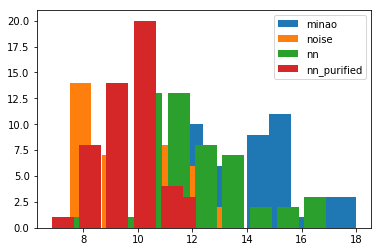

In [28]:
from SCFInitialGuess.utilities.analysis import iterations_histogram

for key, val in iterations.items():
    hist, bins = np.histogram(val)
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=key)
    
plt.legend()
plt.show()
plt.show()